# Low-Rank Structure in Gaussian Covariances

This notebook explores how low-rank changes in Gaussian coefficient matrices affect covariance structure.
The emphasis is on empirical covariance, eigenvalues, and matrix rank.

## Background

$$
x = W z + \varepsilon,\quad z \sim \mathcal{N}(0, I_k),\quad \varepsilon \sim \mathcal{N}(0, \sigma^2 I_d)
$$

$$
\Sigma = W W^\top + \sigma^2 I_d.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvalsh

rng = np.random.default_rng(0)

In [2]:
d = 40
k = 8
sigma = 0.1
n = 1500

W0 = rng.normal(size=(d, k))
Sigma0 = W0 @ W0.T + sigma**2 * np.eye(d)

## Low-Rank vs Diffuse Coefficient Changes

In [5]:
rank_star = 2

B = rng.normal(size=(d, rank_star))
A = rng.normal(size=(rank_star, k))
DeltaW_lr = B @ A

D = rng.normal(size=(d, k))
DeltaW_dense = D / np.linalg.norm(D, 'fro') * np.linalg.norm(DeltaW_lr, 'fro')

In [7]:
def sample(W):
    z = rng.normal(size=(n, k))
    eps = sigma * rng.normal(size=(n, d))
    return z @ W.T + eps

S_lr = (sample(W0 + DeltaW_lr).T @ sample(W0 + DeltaW_lr)) / n
S_dense = (sample(W0 + DeltaW_dense).T @ sample(W0 + DeltaW_dense)) / n

X_lr = sample(W0 + DeltaW_lr)
S_lr = X_lr.T @ X_lr / n

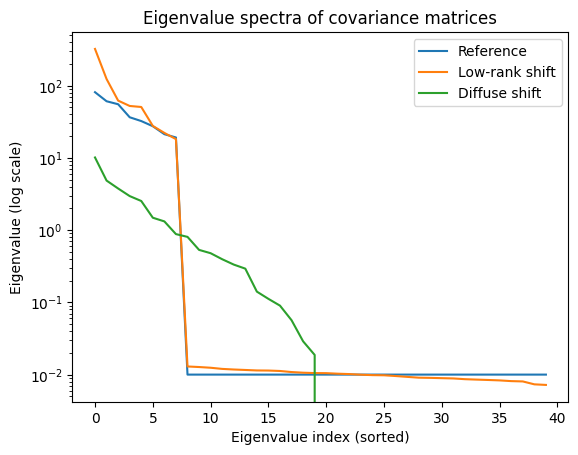

In [8]:
eig0 = eigvalsh(Sigma0)
eig_lr = eigvalsh(S_lr)
eig_dense = eigvalsh(S_dense)

plt.semilogy(eig0[::-1], label='Reference')
plt.semilogy(eig_lr[::-1], label='Low-rank shift')
plt.semilogy(eig_dense[::-1], label='Diffuse shift')
plt.xlabel("Eigenvalue index (sorted)")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Eigenvalue spectra of covariance matrices")
plt.legend()
plt.show()

In [9]:
threshold = 0.10  # 10% relative difference

# Use the same ordering for all three; eigvalsh already gives ascending order
# so you can just compare eig0, eig_lr, eig_dense directly.

rel_diff_lr = np.abs(eig_lr - eig0) / eig0
rel_diff_dense = np.abs(eig_dense - eig0) / eig0

num_changed_lr = np.sum(rel_diff_lr > threshold)
num_changed_dense = np.sum(rel_diff_dense > threshold)

print("Number of significantly changed eigenvalues (low-rank):", num_changed_lr)
print("Number of significantly changed eigenvalues (diffuse):", num_changed_dense)

Number of significantly changed eigenvalues (low-rank): 24
Number of significantly changed eigenvalues (diffuse): 40


### Interpretation

**1. In the low-rank case, how many eigenvalues change and how does this relate to rank?**

In the low-rank case, only a few eigenvalues change by more than 10%. Eigenvalues measure how much variance exists in different directions of the data. Because the coefficient change has low rank, it only adds or changes variance in a small number of directions. As a result, only a few eigenvalues become larger, while the rest stay close to the original values.

**2. In the diffuse case, why are many eigenvalues affected even with the same overall magnitude?**

In the diffuse case, the change is spread across many directions instead of being focused on just a few. Even though the total size of the change is the same, it adds small amounts of variance in many directions. Since eigenvalues represent variance in each direction, many eigenvalues change instead of just a few.

**3. How does this illustrate that rank limits the number of variance directions that can change?**

These results show that matrix rank limits how many directions of variance can be affected. A low-rank change can only modify variance in a small number of directions, which appears as changes in only a few eigenvalues. A high-rank (diffuse) change modifies variance in many directions, causing many eigenvalues to change. This demonstrates that rank controls how many variance directions in the covariance matrix can be altered.